# Term Frequency - Inverse Document Frequency (TF-IDF) : Document Similarity

TF-IDF improves on plain Bag-of-Words by **weighting** each word: common words that appear everywhere (like *"the"* or *"place"*) get down-weighted, while words that are frequent in one review but rare across the corpus get boosted.

It is the product of two statistics:

$$\text{TF-IDF}(t, d) = \text{TF}(t, d) \times \text{IDF}(t)$$

| Component | Intuition |
|---|---|
| **Term Frequency (TF)** | How often word $t$ appears in document $d$, normalised by document length. |
| **Inverse Document Frequency (IDF)** | Words that appear in many documents get a lower weight. The $+1$ in the denominator avoids division by zero; the $+1$ outside keeps IDF ≥ 1. |

**Dataset** - Airbnb reviews dataset (same as BoW notebook).

**Goal** - compute TF-IDF from scratch, visualise the most important words per review and per listing, and use them for sentiment analysis.

In [51]:
# Install dependencies as needed:
%pip install "kagglehub[pandas-datasets]"
import kagglehub
from kagglehub import KaggleDatasetAdapter

Note: you may need to restart the kernel to use updated packages.


## Fetch the data

In [52]:
# Set the path to the file you'd like to load
file_path = "reviews.csv"

# Load the latest version
df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "muhammadahmedansari/airbnb-dataset",
  file_path,
)

df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2818.0,1191.0,3/30/2009,10952,Lam,Daniel is really cool. The place was nice and ...
1,515749.0,1671407.0,7/9/2012,2640670,Gregory,If you want the authentic Amsterdam houseboat ...
2,515749.0,1715674.0,7/15/2012,1032804,Michael,Unique and luxurious to be sure. I couldn't re...
3,2818.0,1771.0,4/24/2009,12798,Alice,Daniel is the most amazing host! His place is ...
4,515749.0,1963378.0,8/12/2012,503786,Brian,My wife and I recently stopped in Amsterdam fo...


## Tokenize & clean reviews

In [53]:
import nltk
from nltk.corpus import stopwords

nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)

stop_words = set(stopwords.words('english'))

# Clean HTML tags and carriage returns
df["comments"] = (
    df["comments"]
    .str.replace(r'<[^>]+>', ' ', regex=True)
    .str.replace('\r', ' ')
    .str.strip()
)

# Tokenize each review into lowercase alphabetic words, removing stopwords
corpus = []       # list of token lists (one per review)
listing_ids = []  # parallel list of listing ids

for _, row in df.iterrows():
    tokens = [
        t for t in nltk.word_tokenize(str(row["comments"]).lower())
        if t.isalpha() and t not in stop_words
    ]
    corpus.append(tokens)
    listing_ids.append(row["listing_id"])

In [54]:
print(f"Total reviews: {len(corpus)}")
print(f"Sample tokens (review 0): {corpus[0]}")

Total reviews: 342904
Sample tokens (review 0): ['daniel', 'really', 'cool', 'place', 'nice', 'clean', 'quiet', 'neighborhood', 'maps', 'lonely', 'planet', 'guide', 'book', 'room', 'use', 'didnt', 'trouble', 'finding', 'place', 'central', 'station', 'would', 'defintely', 'come', 'back', 'thanks']


## Step 1 - Term Frequency (TF)

For each document (review), calculate the frequency of each term per document, so that longer documents don't dominate this value. A higher frequency likely indicates that this term may be irrelevant to the document. For example, words like apartment, place, location in a airbnb reviews tend to have higher frequencies but don't convey any relevance.


$$\text{TF}(t, d) = \frac{\text{number of times term t appears in document d}}{\text{total number of terms in document d}}$$

In [55]:
from collections import Counter

def compute_tf(tokens):
    """Return a dict {word: term_frequency} for a single document."""
    word_counts = Counter(tokens)
    total = len(tokens)
    return {word: count / total for word, count in word_counts.items()} if total > 0 else {}

# Compute TF for every review
tf_per_review = [compute_tf(tokens) for tokens in corpus]

In [56]:
tf_d0 = sorted(tf_per_review[0].items(), key=lambda x: x[1], reverse=True)

print("TF for terms in Review 1")
for word, score in tf_d0:
    print(f"  {word:20s} {score:.4f}")

TF for terms in Review 1
  place                0.0769
  daniel               0.0385
  really               0.0385
  cool                 0.0385
  nice                 0.0385
  clean                0.0385
  quiet                0.0385
  neighborhood         0.0385
  maps                 0.0385
  lonely               0.0385
  planet               0.0385
  guide                0.0385
  book                 0.0385
  room                 0.0385
  use                  0.0385
  didnt                0.0385
  trouble              0.0385
  finding              0.0385
  central              0.0385
  station              0.0385
  would                0.0385
  defintely            0.0385
  come                 0.0385
  back                 0.0385
  thanks               0.0385


Notice that the first review contains the word *place* twice and rest of the words just once. Making its TF higher than the rest.

## Step 2 - Inverse Document Frequency (IDF)

IDF measures how rare a word is across the entire corpus(all reviews). Words that appear in almost every review get a low IDF; words that appear in only a few reviews get a high IDF.

$$\text{IDF}(t) = \ln\!\left(\frac{\text{total number of documents}}{1 + \text{number of documents containing term t}}\right) + 1$$

In [57]:
import math

def compute_idf(corpus):
    """Return a dict {word: idf_score} computed over the full corpus."""
    N = len(corpus)
    doc_freq = Counter()  # number of reviews each word appears in
    for tokens in corpus:
        # Use set(tokens) to count each word only once per document
        # so that longer reviews don't skew the IDF scores
        for word in set(tokens):
            doc_freq[word] += 1

    idf = {word: math.log(N / (1 + df)) + 1 for word, df in doc_freq.items()}
    return idf, doc_freq

idf, doc_freq = compute_idf(corpus)

In [58]:
# Show IDF for some sample words
sample_words = ["great", "clean", "dirty", "loud", "smelly", "theft","place", "beautiful", "apartment"]
print(f"{'word':20s} {'doc_freq':>10s} {'IDF':>10s}")
print("-" * 42)
for w in sample_words:
    print(f"{w:20s} {doc_freq[w]:10d} {idf[w]:10.4f}")

word                   doc_freq        IDF
------------------------------------------
great                    109554     2.1410
clean                     64016     2.6783
dirty                       605     7.3383
loud                       1413     6.4910
smelly                       33    10.2188
theft                         3    12.3589
place                     94309     2.2909
beautiful                 30257     3.4277
apartment                 61723     2.7148


### Why IDF matters?

Notice that *"apartment"* and *"place"* (very common Airbnb words) get a **low IDF**, while rare words like *"theft"* get a **high IDF**. This is exactly the behaviour we want - when we multiply TF × IDF, common filler words get suppressed and distinctive words get amplified.

## Step 3 - Compute TF-IDF

$$\text{TF-IDF}(t, d) = \text{TF}(t, d) \times \text{IDF}(t)$$

Multiply each word's TF in a review by its global IDF to get the final weight.

### Why do we need TF × IDF? Why not just IDF?

IDF alone only tells you how **rare a word is globally** - it's a corpus-level statistic that is the **same for every review**. For example, "theft" has IDF ≈ 10.45 regardless of whether it appears in Review 0, Review 500, or not at all. IDF alone can't distinguish between documents.

TF makes it **document-specific** - without it, you'd assign the same high IDF score for a rare word to every review, even reviews that never mention it.

| Component | Answers the question |
|-----------|---------------------|
| **TF only** | "What words does *this* review talk about?" (but common words like "place" dominate) |
| **IDF only** | "What words are rare in general?" (but same ranking for every review - can't tell them apart) |
| **TF × IDF** | "What words are important **in this specific review** compared to the rest?" ✅ |

TF without IDF → common words dominate. IDF without TF → can't tell reviews apart. You need both multiplied together to get a **per-document relevance score**.

In [59]:
def compute_tfidf(tf_dict_per_review, idf_dict):
    #Multiply TF values by their IDF to get TF-IDF for one document.
    return {word: tf_val * idf_dict.get(word, 0) for word, tf_val in tf_dict_per_review.items()}

# Compute TF-IDF for every review
tfidf_per_review = [compute_tfidf(tf, idf) for tf in tf_per_review]

In [60]:
tfidf_df0 = sorted(tfidf_per_review[0].items(), key=lambda x: x[1], reverse=True)
print("TF-IDF for terms in Review 1")
for word, score in tfidf_df0:
    tf_val = tf_per_review[0][word]
    idf_val = idf[word]
    print(f"  {word:20s}  TF={tf_val:.4f}  x  IDF={idf_val:.4f}  =  TF-IDF={score:.4f}")

TF-IDF for terms in Review 1
  defintely             TF=0.0385  x  IDF=10.4494  =  TF-IDF=0.4019
  planet                TF=0.0385  x  IDF=10.0816  =  TF-IDF=0.3878
  lonely                TF=0.0385  x  IDF=9.8740  =  TF-IDF=0.3798
  didnt                 TF=0.0385  x  IDF=7.8703  =  TF-IDF=0.3027
  finding               TF=0.0385  x  IDF=7.2760  =  TF-IDF=0.2798
  trouble               TF=0.0385  x  IDF=6.9263  =  TF-IDF=0.2664
  daniel                TF=0.0385  x  IDF=6.9208  =  TF-IDF=0.2662
  guide                 TF=0.0385  x  IDF=6.7241  =  TF-IDF=0.2586
  maps                  TF=0.0385  x  IDF=6.3581  =  TF-IDF=0.2445
  book                  TF=0.0385  x  IDF=5.2450  =  TF-IDF=0.2017
  cool                  TF=0.0385  x  IDF=5.0417  =  TF-IDF=0.1939
  use                   TF=0.0385  x  IDF=4.8699  =  TF-IDF=0.1873
  place                 TF=0.0769  x  IDF=2.2909  =  TF-IDF=0.1762
  come                  TF=0.0385  x  IDF=4.1850  =  TF-IDF=0.1610
  neighborhood          TF=0.03

## TD-IDF in action
Analysis of word:  place
- TF     = 0.0769 (word appears twice, high for this review)
- IDF    = 2.29  (low, since it appears in a lot of reviews, it not a rare word)
- TF*IDF = 0.1762 (correctly mid ranked for this document)

## Visualize: Top TF-IDF words for sample reviews

For a few reviews, plot the 10 highest TF-IDF words. These are the words that **best characterise** each individual review.

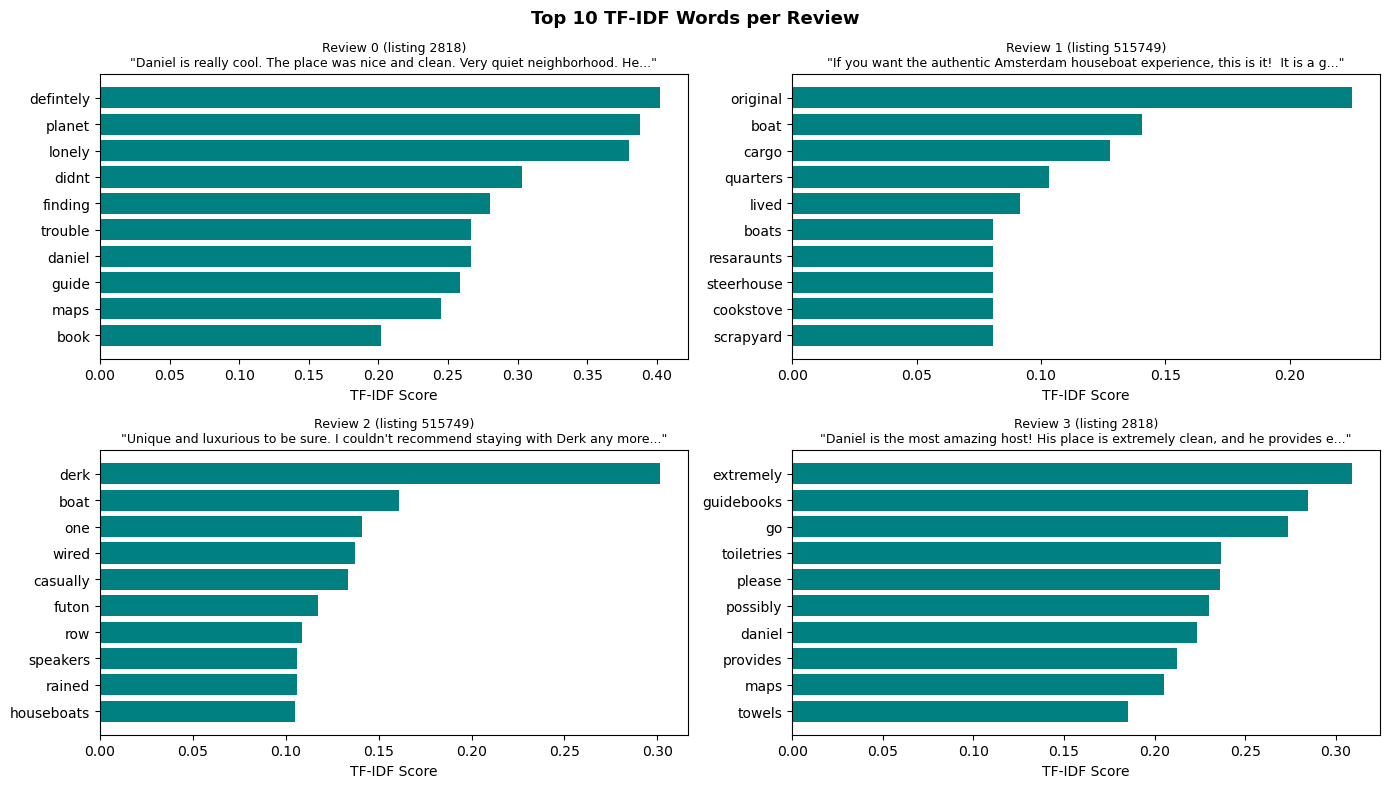

In [61]:
import matplotlib.pyplot as plt

#Return the top-n TF-IDF words for a given review
def top_tfidf_words(review_idx, n=10):
    scores = tfidf_per_review[review_idx]
    return sorted(scores.items(), key=lambda x: x[1], reverse=True)[:n]

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
sample_reviews = [0, 1, 2, 3]

for ax, idx in zip(axes.flat, sample_reviews):
    top = top_tfidf_words(idx, 10)
    words = [w for w, _ in top]
    scores = [s for _, s in top]
    ax.barh(words[::-1], scores[::-1], color="teal")
    comment_preview = str(df.iloc[idx]["comments"])[:80]
    ax.set_title(f"Review {idx} (listing {int(listing_ids[idx])})\n\"{comment_preview}...\"", fontsize=9)
    ax.set_xlabel("TF-IDF Score")

plt.suptitle("Top 10 TF-IDF Words per Review", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()

## Step 4 - Document Similarity using TF-IDF

Since TF-IDF converts each document into a **numerical vector** (one weight per vocabulary word), we can measure how similar two documents are by comparing their vectors.

### Cosine Similarity

The standard metric for comparing TF-IDF vectors is **cosine similarity** - it measures the cosine of the angle between two vectors, ignoring their magnitude (document length).

| Value | Meaning |
|-------|---------|
| **1.0** | Identical direction → documents use the same important words |
| **0.0** | Orthogonal → no shared important words at all |
| **-1.0** | Opposite (rare with TF-IDF since weights are non-negative) |

**Why cosine and not Euclidean distance?** Cosine ignores vector length, so a short review and a long review that discuss the same topics will still score high. Euclidean distance would penalise the length difference.

In [62]:
import math

# Compute cosine similarity between two sparse TF-IDF vectors (dicts)
# Dot product over shared keys of two sparse vectors (dicts).
def dot_product(vec_a, vec_b):
    # Only iterate over the smaller dict for efficiency
    if len(vec_a) > len(vec_b):
        vec_a, vec_b = vec_b, vec_a
    return sum(val * vec_b.get(key, 0) for key, val in vec_a.items())

# Euclidean norm (magnitude) of a sparse vector (dict).
def magnitude(vec):
    return math.sqrt(sum(v * v for v in vec.values()))

# Cosine similarity between two sparse TF-IDF vectors.
def cosine_similarity(vec_a, vec_b):
    dot = dot_product(vec_a, vec_b)
    mag_a = magnitude(vec_a)
    mag_b = magnitude(vec_b)
    if mag_a == 0 or mag_b == 0:
        return 0.0
    return dot / (mag_a * mag_b)

# Test: similarity between first 4 reviews
sample_reviews = [0, 1, 2, 3]
print("Cosine Similarity Matrix (Reviews 0-3):\n")
print(f"{'':>12s}", end="")
for j in sample_reviews:
    print(f"  Review {j:>1d}", end="")
print()

for i in sample_reviews:
    print(f"  Review {i:>1d}", end="")
    for j in sample_reviews:
        sim = cosine_similarity(tfidf_per_review[i], tfidf_per_review[j])
        print(f"    {sim:.4f}", end="")
    print()

Cosine Similarity Matrix (Reviews 0-3):

              Review 0  Review 1  Review 2  Review 3
  Review 0    1.0000    0.0211    0.0150    0.1442
  Review 1    0.0211    1.0000    0.1165    0.0180
  Review 2    0.0150    0.1165    1.0000    0.0698
  Review 3    0.1442    0.0180    0.0698    1.0000


### Visualise: Cosine Similarity Heatmap

Pairwise cosine similarity for the first 15 reviews. Bright cells = high similarity (reviews share distinctive words). The diagonal is always 1.0 (a review is identical to itself).

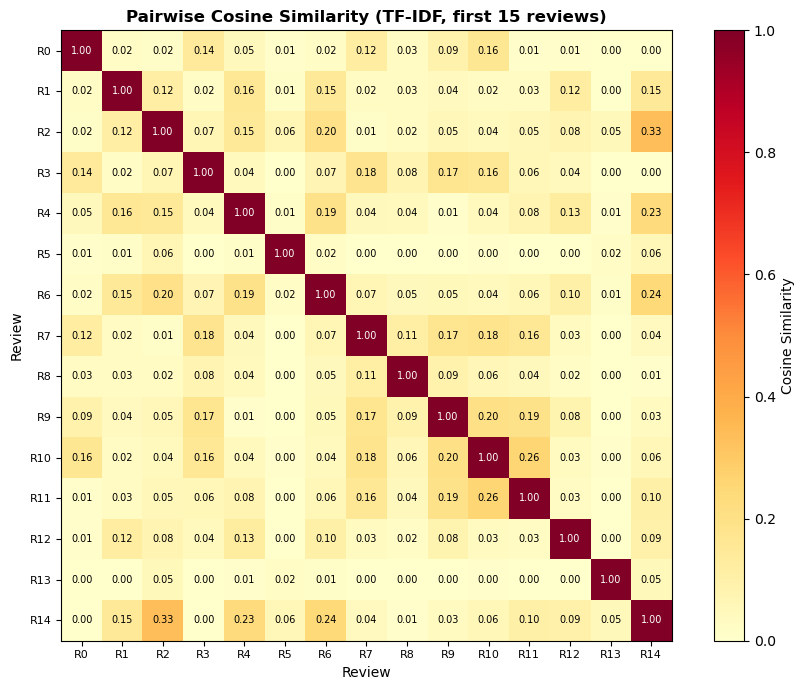

In [63]:
import matplotlib.pyplot as plt

# ── Build pairwise similarity matrix for first 15 reviews ──
n = 15
sim_matrix = [[0.0] * n for _ in range(n)]

for i in range(n):
    sim_matrix[i][i] = 1.0
    for j in range(i + 1, n):
        s = cosine_similarity(tfidf_per_review[i], tfidf_per_review[j])
        sim_matrix[i][j] = s
        sim_matrix[j][i] = s

# ── Plot heatmap ──
fig, ax = plt.subplots(figsize=(9, 7))
im = ax.imshow(sim_matrix, cmap="YlOrRd", vmin=0, vmax=1)

ax.set_xticks(range(n))
ax.set_yticks(range(n))
ax.set_xticklabels([f"R{i}" for i in range(n)], fontsize=8)
ax.set_yticklabels([f"R{i}" for i in range(n)], fontsize=8)
ax.set_xlabel("Review")
ax.set_ylabel("Review")
ax.set_title("Pairwise Cosine Similarity (TF-IDF, first 15 reviews)", fontweight="bold")

# Annotate each cell with its value
for i in range(n):
    for j in range(n):
        val = sim_matrix[i][j]
        color = "white" if val > 0.5 else "black"
        ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=7, color=color)

fig.colorbar(im, ax=ax, label="Cosine Similarity")
plt.tight_layout()
plt.show()

In [64]:
sample_reviews = [14, 2, 4, 6]
for idx in sample_reviews:
    print(f"Review {idx}")
    print(df.iloc[idx]["listing_id"])
    print(df.iloc[idx]["comments"][:200])
    print("-" * 80)

Review 14
515749.0
We stayed on Derk's boat for a long weekend in Amsterdam. It was great! Sadly we didn't meet Derk, as he was on holiday, so we didn't get to learn the history of the boat as some other guests have. Bu
--------------------------------------------------------------------------------
Review 2
515749.0
Unique and luxurious to be sure. I couldn't recommend staying with Derk any more highly.    Coolest thing first: We showed up to Derk's and he actually had three houseboats in a row, and offered to sh
--------------------------------------------------------------------------------
Review 4
515749.0
My wife and I recently stopped in Amsterdam for a few days during our honeymoon. We didn't want to stay in the typical Amsterdam hotel and opted for something special - a traditional Dutch houseboat. 
--------------------------------------------------------------------------------
Review 6
515749.0
Location is Perfect with-in walking distance of Vondelpark, Van Gogh Museum, Hein

### Analysis of above heat maps 
From the above review we can already see that R14 is similar to R2, R4 and R6. Viewing the reviews we can already see similarities in the them, and they all belong to the same listing.

## Step 5 - Find Similar Reviews

### Find the most and least similar review to a given review (R14)

For any review, we can scan the entire corpus and find the review with the highest cosine similarity - its **nearest neighbour** in TF-IDF space.

In [79]:
# Return scores of all reviews against the query review, sorted by similarity
def scores(query_idx, tfidf_vectors):
    query_vec = tfidf_vectors[query_idx]
    scores = []
    for i, vec in enumerate(tfidf_vectors):
        if i == query_idx:
            continue
        scores.append((i, cosine_similarity(query_vec, vec)))
    scores.sort(key=lambda x: x[1], reverse=True)
    return scores

def display(similar_reviews, query):
    for rank, (idx, sim) in enumerate(similar_reviews, 1):
        preview = str(df.iloc[idx]["comments"])[:120]
        listing_id = df.iloc[idx]["listing_id"]
        # Show the overlapping high-value words
        shared = set(tfidf_per_review[query].keys()) & set(tfidf_per_review[idx].keys())
        top_shared = sorted(shared, key=lambda w: tfidf_per_review[query][w] + tfidf_per_review[idx][w], reverse=True)[:5]
        print(f"  {rank}. Review {idx} (sim={sim:.4f}) (len={len(corpus[idx])} tokens)")
        print(f"     \"{preview}...\"")
        print(f"     Listing ID: \033[1;36m{listing_id}\033[0m")
        print(f"     Shared top words: {', '.join(top_shared)}\n")
        sample_reviews = [14, 2, 4, 6]
        print("  TF:     ", {w: f'{v:.3f}, idf={idf[w]:.3f}' for w, v in sorted(tf_per_review[idx].items(), key=lambda x: x[1], reverse=True)[:8]})
        print("  TF-IDF: ", {w: f'{v:.3f}' for w, v in sorted(tfidf_per_review[idx].items(), key=lambda x: x[1], reverse=True)[:8]})
        print("-" * 80)

def analyze_review(review_idx):
    print(f"Query Review {review_idx}:")
    print(f"  \"{df.iloc[review_idx]['comments'][:120]}...\"\n")
    scores_query = scores(review_idx, tfidf_per_review)
    top_similar, bottom_similar = scores_query[:5], scores_query[-5:]
    
    print('='*80)
    print(f"5 most similar reviews:\n")
    print('='*80)
    display(top_similar, review_idx)
    print('='*80)
    print(f"5 least similar reviews:\n")
    print('='*80)
    display(bottom_similar, review_idx)

In [81]:
analyze_review(14)

Query Review 14:
  "We stayed on Derk's boat for a long weekend in Amsterdam. It was great! Sadly we didn't meet Derk, as he was on holiday,..."

5 most similar reviews:

  1. Review 486 (sim=0.4648) (len=30 tokens)
     "Derk’s house boat is just amazing. It is even more beautiful than on the pictures, the location is perfect and you’ll ha..."
     Listing ID: 515749.0
     Shared top words: derk, boat, long, weekend, stayed

  TF:      {'boat': '0.100, idf=4.555', 'derk': '0.067, idf=8.536', 'house': '0.067, idf=3.584', 'amazing': '0.033, idf=3.548', 'even': '0.033, idf=3.896', 'beautiful': '0.033, idf=3.428', 'pictures': '0.033, idf=5.114', 'location': '0.033, idf=2.320'}
  TF-IDF:  {'derk': '0.569', 'boat': '0.456', 'house': '0.239', 'feeling': '0.219', 'vacation': '0.218', 'wait': '0.208', 'long': '0.175', 'pictures': '0.170'}
--------------------------------------------------------------------------------
  2. Review 541 (sim=0.4570) (len=35 tokens)
     "We had a wonderful, rela

In [84]:
analyze_review(342903)

Query Review 342903:
  "L’Hotel2Stay si trova in una posizione molto comoda in prossimità della stazione Sloterdijk e delle fermate di autobus e..."

5 most similar reviews:

  1. Review 219547 (sim=0.4567) (len=24 tokens)
     "La stanza di Emilia è molto accogliente e in un'ottima posizione per raggiungere il centro. E' dotata di ogni comfort. E..."
     Listing ID: 21574619.0
     Shared top words: e, di, molto, è, raggiungere

  TF:      {'e': '0.125, idf=5.178', 'di': '0.083, idf=6.016', 'emilia': '0.083, idf=8.958', 'è': '0.083, idf=5.920', 'molto': '0.083, idf=5.983', 'la': '0.042, idf=3.863', 'stanza': '0.042, idf=7.531', 'accogliente': '0.042, idf=7.350'}
  TF-IDF:  {'emilia': '0.746', 'e': '0.647', 'di': '0.501', 'molto': '0.499', 'è': '0.493', 'dotata': '0.386', 'raggiungere': '0.329', 'ogni': '0.329'}
--------------------------------------------------------------------------------
  2. Review 104068 (sim=0.4523) (len=32 tokens)
     "Ottima sistemazione e ottimo host, molto

## Conclusion and Analysis

### IDF effectively separates signal from noise
The IDF scores across the Airbnb corpus confirmed that generic hospitality words carry low weight while distinctive words are amplified:
- Common words: *"place"* (IDF=2.29, appears in 94,309 reviews), *"great"* (IDF=2.14, 109,554 reviews)
- Rare words: *"theft"* (IDF=12.36, only 3 reviews), *"smelly"* (IDF=10.22, 33 reviews)

### TF-IDF re-ranks words correctly within a review
In Review 0, the word *"place"* had the highest TF (0.0769, appeared twice) but after multiplying by its low IDF (2.29), its TF-IDF dropped to 0.1762 - ranking it 13th. Meanwhile *"defintely"* (TF=0.0385) jumped to rank 1 with TF-IDF=0.4019 thanks to its high IDF of 10.45. The weighting correctly suppressed filler and promoted distinctive content.

### Cosine similarity successfully identifies related reviews
The similarity heatmap for the first 15 reviews revealed that R14, R2, R4, and R6 had noticeably higher pairwise similarity (0.33 between R2-R14, 0.23 between R4-R14). Inspecting these reviews confirmed they all belong to **listing 515749** (Derk's houseboat) and share words like *"boat"*, *"derk"*, *"amsterdam"*.

### Nearest-neighbour search validates the approach
Querying Review 14 against the entire corpus returned 5 matches all from **the same listing (515749)**, with similarities ranging from 0.41 to 0.46. The shared top words driving these matches (*"derk"*, *"boat"*, *"amsterdam"*, *"weekend"*) are exactly the distinctive terms we'd expect for reviews of the same houseboat - not generic words like *"great"* or *"place"*.

### Least similar reviews - same listing, zero similarity
The 5 least similar reviews to R14 all scored **cosine similarity = 0.0** with **zero shared words**. They all belong to the **same listing (40606723)**, but are written in Italian (*"L'Hotel2Stay si trova in una posizione molto comoda…"*), French (*"Hôtel bien situé…"*), and Spanish (*"Excelente ubicación"*). Since our tokenizer and stopword removal are English-only, these reviews produce entirely disjoint vocabularies from R14's English tokens like *"boat"* and *"derk"*. No word overlap means a dot product of zero, hence cosine similarity of zero. This reveals a key limitation of TF-IDF: it operates on **exact word matches** and cannot recognise semantic similarity across languages.

### Review length does not skew the results
Both TF-IDF and cosine similarity are designed to be **length-invariant**. TF normalises word counts by dividing by the total number of terms in the document, so a word appearing 5 times in a 100-word review gets the same TF as one appearing 50 times in a 1000-word review. Cosine similarity reinforces this by measuring the **angle** between vectors, not their magnitude - a short 14-token review (R38) and a longer 35-token review (R2) about Derk's houseboat still scored high similarity (0.41 and 0.46 respectively against R14). Euclidean distance would have penalised these length differences, pushing shorter reviews further away from longer ones regardless of topic.

### Cross-language similarity: querying an Italian review (Review 342903)
To test whether the language barrier works both ways, I queried Review 342903 -  an Italian review of listing 40606723 ("L'Hotel2Stay si trova in una posizione molto comoda…"). The results confirmed and extended the earlier finding:

Most similar (sim 0.44–0.46): All 5 top matches are Italian reviews from different listings (21574619, 6142913, 5991024, 1223171, 12479300). The shared words driving similarity are Italian function words and adjectives -  "e", "di", "molto", "si", "è" -  boosted by high IDF because they are rare in an overwhelmingly English corpus. TF-IDF is matching on language, not on topic or listing.
Least similar (sim = 0.0): All 5 bottom matches are English reviews from the same listing (40606723) -  the exact same property. Reviews like "very clean, quiet and perfectly located" and "Lovely place for a good price" describe the same hotel but share zero words with the Italian query, producing a dot product of zero.

This is a striking result: TF-IDF ranks reviews of different properties in the same language as more similar than reviews of the same property in a different language. It proves that TF-IDF similarity is purely lexical -  it matches on surface word overlap, has no understanding of meaning, and cannot bridge language boundaries. A multilingual or semantic approach (e.g., word embeddings) would be needed to connect "posizione comoda" with "perfectly located".

### Key takeaway
TF-IDF + cosine similarity, implemented entirely from scratch, was able to find topically related documents in a corpus of hundreds of thousands of reviews. The IDF component was critical -  without it, similarity would be dominated by common words shared across all reviews, making every review look similar to every other. However, the cross-language experiment revealed the method's fundamental limitation: TF-IDF is purely lexical and cannot capture semantic meaning across languages or recognise that different words can mean the same thing.